In [1]:
## if using Domino's ray, start ray this way

import ray
import os

#if ray.is_initialized() == False:
#   service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
#   service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
#   ray.util.connect(f"{service_host}:{service_port}")

In [2]:
#ray.init()

In [3]:
## if using on laptop do the following

#!pip install --user ray==1.7
#!pip install --user sync
#!pip install --user aioredis==1.3.0

In [4]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

In [5]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [6]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [8]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio



def create_env(config):
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

In [9]:
ray.shutdown()
ray.init()

2021-11-16 21:20:34,654	INFO services.py:1253 -- View the Ray dashboard at http://127.0.0.1:8265
2021-11-16 21:20:34,657	WARNING services.py:1720 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.68gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


{'node_ip_address': '100.96.7.135',
 'raylet_ip_address': '100.96.7.135',
 'redis_address': '100.96.7.135:6379',
 'object_store_address': '/tmp/ray/session_2021-11-16_21-20-33_175119_1070/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-16_21-20-33_175119_1070/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-11-16_21-20-33_175119_1070',
 'metrics_export_port': 64544,
 'node_id': '6d004c26ce0fab43b5608199b1a079c66e7d874b8976a80a6ee5149e'}

In [10]:
import os
local_dir = '/domino/datasets/local/{}'.format(os.environ['DOMINO_PROJECT_NAME'])

analysis = tune.run(
    "DQN",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 3,  ##adjust number of workers
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter"
    },
    checkpoint_at_end=True,
    checkpoint_freq = 1,
    local_dir = local_dir
)

Trial name,status,loc
DQN_TradingEnv_0a92f_00000,PENDING,


(pid=1189) 2021-11-16 21:20:39,955	INFO dqn.py:141 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


Trial name,status,loc
DQN_TradingEnv_0a92f_00000,RUNNING,


(pid=1186) 2021-11-16 21:20:43,049	INFO rollout_worker.py:1540 -- Validating sub-env at vector index=0 ... (ok)
(pid=1186) 2021-11-16 21:20:43,050	DEBUG rollout_worker.py:1363 -- Creating policy for default_policy
(pid=1186) 2021-11-16 21:20:43,055	DEBUG catalog.py:702 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f999e34ebb0>: Box([[-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-inf -inf -inf -inf -inf]
(pid=1186)  [-i

(pid=1189) 2021-11-16 21:20:44,270	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,288	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=1011, mean_mean=79.11848762795532, mean_std=30.547195007877797), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 1008
  custom_metrics: {}
  date: 2021-11-16_21-20-44
  done: false
  episode_len_mean: .nan
  episode_media: {}
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 1008
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.1
          grad_gnorm: 4.107741355895996
          max_q: 0.5496186017990112
          mean_q: -0.015400819480419159
          min_q: -0.8679937124252319
        mean_td_error: -0.015400797128677368
        model: {}
        td_error: "[-0.47778583 -1.2498623   0.7138305   0.8603549  -0.9476882  -0.7557616\n\
          \  1.0792382  -0.88239753 -0.92033255 -0.45109427  1.103218    0.9010031\n\
          \ -0.4503814  

(pid=1189) 2021-11-16 21:20:44,416	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,443	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,469	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,502	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,532	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,561	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,591	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,620	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,646	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44,803	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:44

(pid=1189) 2021-11-16 21:20:47,117	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,148	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,172	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,188	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=2022, mean_mean=87.927893384541, mean_std=29.103261333184086), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,2,3.91485,2016,7.69606,24.6699,-16.7944,532.667


(pid=1189) 2021-11-16 21:20:47,328	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,353	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,381	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,409	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,435	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,462	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,490	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,515	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,540	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47,564	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:47

(pid=1189) 2021-11-16 21:20:49,553	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,577	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,602	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,632	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,663	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,688	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,716	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,732	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=3030, mean_mean=85.35908520397247, mean_std=28.71853362814905), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 3024
  custom_metrics: {}
  date: 2021-11-16_21-20-49
  done: false
  episode_len_mean: 532.6666666666666
  episode_media: {}
  episode_reward_max: 24.669882550827623
  episode_reward_mean: 7.696061381695411
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 3
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 3024
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.0007988
          grad_gnorm: 1.702688455581665
          max_q: 1.7952839136123657
          mean_q: -0.4382844865322113
          min_q: -1.9578533172607422
        mean_td_error: -0.2507844865322113
        model: {}
        td_error: "[-3.3136082e-01 -1.8534541e-02 -2.1109337e-01  1.1277366e-01\n -8.4811687e-02\
          \ -7.7024031e-01 -1.6047823e-01  9.3004

(pid=1189) 2021-11-16 21:20:49,853	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,883	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,909	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,939	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,970	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:49,999	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:50,026	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:50,055	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:50,083	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:50,113	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:50

(pid=1189) 2021-11-16 21:20:52,280	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,311	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,341	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,365	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,394	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,419	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,443	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,468	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,493	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52,518	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:52

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,4,8.63907,4032,18.4863,50.8571,-16.7944,545.25


(pid=1189) 2021-11-16 21:20:53,203	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,235	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,265	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,296	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,325	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,351	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,375	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,403	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,431	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53,460	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:53

(pid=1189) 2021-11-16 21:20:55,424	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,453	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,481	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,507	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,535	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,563	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,591	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,620	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,649	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55,678	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:55

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 6048
  custom_metrics: {}
  date: 2021-11-16_21-20-57
  done: false
  episode_len_mean: 696.8333333333334
  episode_media: {}
  episode_reward_max: 188.51166061874625
  episode_reward_mean: 72.18710448013736
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 6
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 6048
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.0004964
          grad_gnorm: 0.46473321318626404
          max_q: 1.5615427494049072
          mean_q: 0.5092368721961975
          min_q: -1.2001073360443115
        mean_td_error: 0.1342368870973587
        model: {}
        td_error: "[ 0.08480096 -0.1472593  -0.09810519 -0.07274842  0.05242991  1.3030782\n\
          \ -0.21275866  0.10373807 -0.04747057  0.25

(pid=1189) 2021-11-16 21:20:57,152	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,182	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,211	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,236	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,267	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,293	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,322	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,351	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,380	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57,408	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:57

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,6,13.2809,6048,72.1871,188.512,-16.7944,696.833


(pid=1189) 2021-11-16 21:20:59,179	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,207	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,235	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,264	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,293	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,318	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,343	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,368	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,395	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59,421	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:20:59

(pid=1189) 2021-11-16 21:21:01,410	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,437	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,461	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,485	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,512	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,538	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,561	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,588	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,617	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01,646	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:01

(pid=1189) 2021-11-16 21:21:03,658	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,684	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,708	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,737	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,762	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,790	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,818	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,846	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,871	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03,896	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:03

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 9072
  custom_metrics: {}
  date: 2021-11-16_21-21-04
  done: false
  episode_len_mean: 797.8888888888889
  episode_media: {}
  episode_reward_max: 369.07254751664965
  episode_reward_mean: 156.34083290100375
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 9
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 9072
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.00019400000000000005
          grad_gnorm: 0.39399033784866333
          max_q: 1.4707125425338745
          mean_q: 0.670063316822052
          min_q: -1.2431511878967285
        mean_td_error: -0.1111866757273674
        model: {}
        td_error: "[-0.14166117 -0.09119701 -0.11730671  0.06672728 -0.02833003  0.24195337\n\
          \ -0.07694727 -0.38924128  0

(pid=1189) 2021-11-16 21:21:04,057	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,084	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,109	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,134	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,151	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=9084, mean_mean=82.0822762553876, mean_std=28.445843256273157), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,9,20.075,9072,156.341,369.073,-16.7944,797.889


(pid=1189) 2021-11-16 21:21:04,276	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,304	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,327	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,350	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,378	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,408	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,434	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,463	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,488	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04,513	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:04

(pid=1189) 2021-11-16 21:21:06,371	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,398	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,426	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,454	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,469	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=10093, mean_mean=81.85225539644472, mean_std=28.43864871089935), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:06,584	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,611	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,638	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:06,667	DEBUG train_ops.py:183 -- == sgd epochs 

(pid=1189) 2021-11-16 21:21:08,512	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,539	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,561	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,589	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,615	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,639	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,667	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,695	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:08,711	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=11103, mean_mean=81.64725583260625, mean_std=28.541912236204283), (n=0, mean_mea

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,11,24.4227,11088,244.504,530.197,-16.7944,848.417


(pid=1189) 2021-11-16 21:21:09,759	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,782	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,809	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,837	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,861	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,887	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,915	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,943	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,966	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:09,989	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:10

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 12096
  custom_metrics: {}
  date: 2021-11-16_21-21-11
  done: false
  episode_len_mean: 848.4166666666666
  episode_media: {}
  episode_reward_max: 530.1970208459568
  episode_reward_mean: 244.50363742858906
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 12
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 12096
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.7916e-05
          grad_gnorm: 0.15567557513713837
          max_q: 1.3034151792526245
          mean_q: 0.6477680802345276
          min_q: -0.9784681797027588
        mean_td_error: 0.0852680578827858
        model: {}
        td_error: "[-0.22689241 -0.08135927 -0.08537292 -0.02319551 -0.06093031  0.06353807\n\
          \  0.0182029   0.18643194 -0.01956338 

(pid=1189) 2021-11-16 21:21:11,153	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,178	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,202	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,229	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,255	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,282	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,305	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,331	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,355	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11,382	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:11

(pid=1189) 2021-11-16 21:21:13,075	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,104	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,136	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,165	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,190	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,221	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,250	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,275	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:13,291	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=13120, mean_mean=81.37619466197118, mean_std=28.41666626909932), (n=0, mean_mean

(pid=1189) 2021-11-16 21:21:15,081	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,110	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,135	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,162	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,189	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,215	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,243	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,269	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,293	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,317	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,13,28.7894,13104,270.502,582.48,-16.7944,860.077


(pid=1189) 2021-11-16 21:21:15,393	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,417	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,443	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,470	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,497	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,523	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,547	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:15,565	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=14130, mean_mean=81.24648196591546, mean_std=28.497058657323148), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:15,677	DEBUG train_ops.py:183 -- == sgd epochs

(pid=1189) 2021-11-16 21:21:17,514	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,543	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,567	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,596	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,621	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,649	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,678	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,706	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,734	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17,758	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:17

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 15120
  custom_metrics: {}
  date: 2021-11-16_21-21-17
  done: false
  episode_len_mean: 878.7333333333333
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 312.49714566356954
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 15
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 15120
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.4892e-05
          grad_gnorm: 0.16443078219890594
          max_q: 1.2133325338363647
          mean_q: 0.6601735353469849
          min_q: -1.2499971389770508
        mean_td_error: -0.027326460927724838
        model: {}
        td_error: "[-0.20086753 -0.07380581 -0.1523189  -0.02491355 -0.19912326 -0.11628568\n\
          \ -0.15037012  0.21333253 -0.249997

(pid=1189) 2021-11-16 21:21:18,050	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,074	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,098	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,123	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,150	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,177	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,200	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,229	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,256	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18,281	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:18

(pid=1189) 2021-11-16 21:21:20,163	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,192	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,220	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,249	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,265	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=16147, mean_mean=81.07253458352713, mean_std=28.398474929248437), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:20,375	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,403	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,429	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:20,453	DEBUG train_ops.py:183 -- == sgd epochs

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,16,35.4548,16128,329.509,591.641,-16.7944,886.312


(pid=1189) 2021-11-16 21:21:21,260	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,286	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,313	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,337	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,366	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,393	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,418	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,442	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,466	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21,496	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:21

(pid=1189) 2021-11-16 21:21:23,399	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,428	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,457	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,482	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,508	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,532	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,556	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,580	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,606	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23,631	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:23

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 18144
  custom_metrics: {}
  date: 2021-11-16_21-21-25
  done: false
  episode_len_mean: 898.9444444444445
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 358.22937888691627
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 18144
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.186800000000001e-05
          grad_gnorm: 0.1216648742556572
          max_q: 1.160768747329712
          mean_q: 0.8177024126052856
          min_q: -0.9657315015792847
        mean_td_error: -0.05729757994413376
        model: {}
        td_error: "[-1.6329923  -0.00831467  0.0574435  -0.06927657 -0.10558307 -0.09725314\n\
          \  0.03261018 -0.17386258 -

(pid=1189) 2021-11-16 21:21:25,214	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,241	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,267	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,291	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,318	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,345	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,368	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,392	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,415	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25,443	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:25

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,18,40.0183,18144,358.229,591.641,-16.7944,898.944


(pid=1189) 2021-11-16 21:21:27,143	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,171	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,199	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,229	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,255	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,279	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,302	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,330	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,354	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27,381	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:27

(pid=1189) 2021-11-16 21:21:29,172	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,200	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,228	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,254	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,280	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,304	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,328	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,354	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,383	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29,410	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:29

(pid=1189) 2021-11-16 21:21:31,195	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,221	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,244	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,268	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,292	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,315	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,341	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,369	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,393	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31,420	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:31

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 21168
  custom_metrics: {}
  date: 2021-11-16_21-21-31
  done: false
  episode_len_mean: 913.3809523809524
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 390.6172089971035
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 21
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 21168
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.8844e-05
          grad_gnorm: 0.21120817959308624
          max_q: 1.3377876281738281
          mean_q: 0.8315860033035278
          min_q: -1.1269769668579102
        mean_td_error: 0.05033597722649574
        model: {}
        td_error: "[ 0.01636982  0.9502128   0.07019222  0.05763054 -0.01203799  0.04779053\n\
          \  0.01451123  0.01224244 -0.09012783 

(pid=1189) 2021-11-16 21:21:32,075	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,104	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,128	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,152	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,175	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,198	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,221	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,244	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,267	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32,295	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:32

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,21,46.6398,21168,390.617,591.641,-16.7944,913.381


(pid=1189) 2021-11-16 21:21:33,021	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,044	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,068	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,091	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,118	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,143	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,170	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,198	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,226	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33,253	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:33

(pid=1189) 2021-11-16 21:21:35,157	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,180	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,203	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,227	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,252	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,281	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,309	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,335	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,363	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35,390	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:35

(pid=1189) 2021-11-16 21:21:37,167	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,192	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,220	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,248	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,272	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,299	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,322	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,349	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,373	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37,396	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:37

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,23,50.9773,23184,414.859,591.641,-16.7944,924.208


(pid=1189) 2021-11-16 21:21:38,500	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,525	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,551	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,575	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,599	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,623	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,648	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,672	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,698	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,725	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 24192
  custom_metrics: {}
  date: 2021-11-16_21-21-38
  done: false
  episode_len_mean: 924.2083333333334
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 414.85871822523137
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 24
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 24192
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.582e-05
          grad_gnorm: 0.08102454990148544
          max_q: 1.0627261400222778
          mean_q: 0.6252102255821228
          min_q: -1.0816102027893066
        mean_td_error: 0.00021020881831645966
        model: {}
        td_error: "[-9.2071295e-03  8.3406448e-02 -1.1403024e-02 -3.9079785e-02\n -6.5804720e-03\
          \ -7.0766211e-03 -4.3598175e-02 

(pid=1189) 2021-11-16 21:21:38,913	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,938	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,962	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:38,989	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39,016	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39,041	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39,069	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39,094	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39,119	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39,143	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:39

(pid=1189) 2021-11-16 21:21:41,017	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,042	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,057	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=25228, mean_mean=80.57609966549931, mean_std=28.364209746380894), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:41,170	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,197	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,222	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,250	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,277	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:41,301	DEBUG train_ops.py:183 -- == sgd epochs

(pid=1189) 2021-11-16 21:21:43,149	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:43,178	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:43,208	INFO replay_buffer.py:48 -- Estimated max memory usage for replay buffer is 0.05245 GB (50000.0 batches of size 1, 1049 bytes each), available system memory is 33.185693696 GB
(pid=1189) 2021-11-16 21:21:43,211	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:43,240	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1185) 2021-11-16 21:21:43,192	INFO sampler.py:1015 -- Inputs to compute_actions():
(pid=1185) 
(pid=1185) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1185)                                   'env_id': 0,
(pid=1185)                                   'info': { 'net_worth': 413984.61247774784,
(pid=1185)                                             'step': 593},
(pid=1185)         

(pid=1189) 2021-11-16 21:21:44,083	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,111	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,135	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,163	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,187	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,213	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,243	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,270	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,295	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,323	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,26,57.524,26208,433.732,591.641,-16.7944,932.63


(pid=1189) 2021-11-16 21:21:44,377	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,405	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,436	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,465	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,492	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,520	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,545	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,570	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,597	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44,621	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:44

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 27216
  custom_metrics: {}
  date: 2021-11-16_21-21-45
  done: false
  episode_len_mean: 932.6296296296297
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 433.7317485263255
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 27
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 27216
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.2796e-05
          grad_gnorm: 0.1577308475971222
          max_q: 1.1028262376785278
          mean_q: 0.9139252305030823
          min_q: -0.8582794666290283
        mean_td_error: 0.03892524167895317
        model: {}
        td_error: "[ 2.05338001e-02  1.41720533e-01  2.10847855e-02  9.24209356e-02\n\
          \ -4.45492983e-01  1.26767039e+00 -1.76072717e-

(pid=1189) 2021-11-16 21:21:45,892	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:45,918	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:45,947	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:45,976	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46,004	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46,029	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46,057	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46,087	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46,114	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46,137	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:46

(pid=1189) 2021-11-16 21:21:47,913	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:47,938	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:47,963	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:47,994	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:48,024	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:48,053	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:48,080	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:48,097	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=28255, mean_mean=80.47537661072391, mean_std=28.35746856772935), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:48,199	DEBUG train_ops.py:183 -- == sgd epochs 

(pid=1189) 2021-11-16 21:21:50,053	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,083	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,108	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,136	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,161	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,189	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,213	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,243	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,28,62.0887,28224,439.226,591.641,-16.7944,935.036


(pid=1189) 2021-11-16 21:21:50,271	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,300	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,329	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,354	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,379	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,402	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,426	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:50,441	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=29265, mean_mean=80.43767602629393, mean_std=28.397515020823064), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:50,544	DEBUG train_ops.py:183 -- == sgd epochs

(pid=1189) 2021-11-16 21:21:52,294	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,321	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,348	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,373	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,401	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,427	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,453	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,480	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,507	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,534	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 30240
  custom_metrics: {}
  date: 2021-11-16_21-21-52
  done: false
  episode_len_mean: 939.3666666666667
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 449.0049451188712
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 30240
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.977200000000001e-05
          grad_gnorm: 0.11828587204217911
          max_q: 1.0818332433700562
          mean_q: 0.750913143157959
          min_q: -0.9957665205001831
        mean_td_error: 0.0009131785482168198
        model: {}
        td_error: "[-6.4718366e-02 -2.2500962e-01 -1.2540400e-01  6.7399740e-03\n -6.5065622e-03\
          \ -2.7145863e-02  3.129

(pid=1189) 2021-11-16 21:21:52,842	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,871	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,896	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,921	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,946	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:52,973	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:53,000	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:53,024	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:53,047	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:53,070	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:53

(pid=1189) 2021-11-16 21:21:54,825	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,849	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,873	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,900	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,926	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,949	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,972	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:54,992	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=31282, mean_mean=80.3917922854481, mean_std=28.352308247479623), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:21:55,102	DEBUG train_ops.py:183 -- == sgd epochs 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,31,68.6996,31248,453.508,591.641,-16.7944,941.323


(pid=1189) 2021-11-16 21:21:56,042	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,071	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,098	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,127	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,152	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,176	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,200	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,226	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,250	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56,275	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:56

(pid=1189) 2021-11-16 21:21:58,058	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,082	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,107	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,130	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,157	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,180	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,204	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,232	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,260	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58,288	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:58

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 33264
  custom_metrics: {}
  date: 2021-11-16_21-21-59
  done: false
  episode_len_mean: 944.8787878787879
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 461.16838467851176
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 33
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 33264
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.6748e-05
          grad_gnorm: 0.09414581209421158
          max_q: 1.1906094551086426
          mean_q: 0.8255079984664917
          min_q: -1.1418370008468628
        mean_td_error: -0.01824202761054039
        model: {}
        td_error: "[-7.3114753e-02  3.4984231e-02 -2.9619098e-02 -1.3020217e-02\n  1.3961792e-03\
          \ -1.4183700e-01 -7.4387133e-02 -

(pid=1189) 2021-11-16 21:21:59,712	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,740	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,764	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,788	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,811	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,835	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,859	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,886	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,914	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59,939	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:21:59

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,33,73.1103,33264,461.168,591.641,-16.7944,944.879


(pid=1189) 2021-11-16 21:22:01,797	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:01,826	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:01,854	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:01,871	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=34309, mean_mean=80.32111987610118, mean_std=28.348405006122636), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:22:01,982	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:02,011	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:02,039	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:02,064	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:02,089	DEBUG train_ops.py:183 -- == sgd epochs

(pid=1189) 2021-11-16 21:22:03,819	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:03,848	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:03,875	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:03,903	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:03,929	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:03,958	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:03,982	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:04,010	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:04,034	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:04,058	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:04

(pid=1189) 2021-11-16 21:22:06,053	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,084	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,111	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,136	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,162	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,187	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,215	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,241	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,270	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,298	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 36288
  custom_metrics: {}
  date: 2021-11-16_21-22-06
  done: false
  episode_len_mean: 949.4722222222222
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 471.66477228940647
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 36288
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.3724e-05
          grad_gnorm: 0.16809380054473877
          max_q: 1.1625083684921265
          mean_q: 0.9454346895217896
          min_q: 0.3071550130844116
        mean_td_error: 0.07043470442295074
        model: {}
        td_error: "[-1.96993530e-01 -3.80225480e-01  5.68076372e-02 -3.97151113e-02\n\
          \  5.23346663e-02 -2.71013975e-02  7.28027821e

(pid=1189) 2021-11-16 21:22:06,476	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,500	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,517	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=36327, mean_mean=80.27992756865987, mean_std=28.346246858516746), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:22:06,625	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,656	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,686	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,714	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,739	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:06,766	DEBUG train_ops.py:183 -- == sgd epochs

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,36,79.7389,36288,471.665,591.641,-16.7944,949.472


(pid=1189) 2021-11-16 21:22:07,582	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,610	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,638	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,662	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,688	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,717	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,745	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,772	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,801	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07,829	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:07

(pid=1189) 2021-11-16 21:22:10,114	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,139	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,164	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,189	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,214	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,238	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,264	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,295	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,324	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10,356	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:10

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 38304
  custom_metrics: {}
  date: 2021-11-16_21-22-11
  done: false
  episode_len_mean: 953.3589743589744
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 480.45694056141514
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 2
  episodes_total: 39
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 38304
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.1708e-05
          grad_gnorm: 0.16144300997257233
          max_q: 1.1847697496414185
          mean_q: 0.9834724068641663
          min_q: 0.4505366384983063
        mean_td_error: -0.016527589410543442
        model: {}
        td_error: "[ 0.05269074  0.03819966 -0.03712451 -0.02208465  0.1425848   0.04494846\n\
          \  0.06480622  0.01250613 -0.0752129

(pid=1189) 2021-11-16 21:22:11,726	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,754	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,778	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,806	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,832	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,860	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,885	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,909	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,934	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11,958	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:11

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,38,84.577,38304,480.457,591.641,-16.7944,953.359


(pid=1189) 2021-11-16 21:22:12,634	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,661	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,690	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,717	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,741	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,764	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,787	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,810	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,838	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12,863	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:12

(pid=1189) 2021-11-16 21:22:14,664	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,693	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,718	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,746	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,774	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,797	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,824	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,848	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,872	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14,901	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:14

(pid=1189) 2021-11-16 21:22:16,700	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,729	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,758	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,783	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,813	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,838	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,868	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,896	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,926	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16,954	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:16

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,40,88.962,40320,483.026,591.641,-16.7944,954.525


(pid=1189) 2021-11-16 21:22:18,222	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,251	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,276	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,301	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,330	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,360	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,386	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,415	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,444	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,473	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 41328
  custom_metrics: {}
  date: 2021-11-16_21-22-18
  done: false
  episode_len_mean: 956.6904761904761
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 487.91259597587134
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 2
  episodes_total: 42
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 41328
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 6.868400000000001e-05
          grad_gnorm: 0.20641246438026428
          max_q: 1.1928781270980835
          mean_q: 0.9348005652427673
          min_q: -0.9844453930854797
        mean_td_error: 0.12230055034160614
        model: {}
        td_error: "[ 0.01555461  0.0147177   1.2816288   0.0973109   0.13841462 -0.01609653\n\
          \  1.2264875  -0.11671627 

(pid=1189) 2021-11-16 21:22:18,630	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,659	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,684	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,709	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,737	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,766	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,796	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,825	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,851	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18,877	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:18

(pid=1189) 2021-11-16 21:22:20,741	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:20,765	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:20,788	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:20,816	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:20,843	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:20,859	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=42381, mean_mean=80.1769389462266, mean_std=28.342226839204166), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:22:20,969	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:20,993	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:21,023	DEBUG train_ops.py:183 -- == sgd epochs 

(pid=1189) 2021-11-16 21:22:22,775	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,798	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,825	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,848	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,871	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,899	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,927	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,951	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,975	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:22,997	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:23

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,43,95.6303,43344,490.283,591.641,-16.7944,957.698


(pid=1189) 2021-11-16 21:22:24,108	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,135	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,164	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,189	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,217	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,240	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,265	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,290	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,318	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24,342	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:24

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 44352
  custom_metrics: {}
  date: 2021-11-16_21-22-25
  done: false
  episode_len_mean: 959.5777777777778
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 494.59511584205916
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 2
  episodes_total: 45
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 44352
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 6.566e-05
          grad_gnorm: 0.12242453545331955
          max_q: 1.1105225086212158
          mean_q: 0.8606597185134888
          min_q: -0.9084609150886536
        mean_td_error: -0.014340247958898544
        model: {}
        td_error: "[-4.50545549e-03  9.29203033e-02  7.67738819e-02  8.71539116e-03\n\
          \  5.80209494e-02  4.16666269e-02 -7.4626445

(pid=1189) 2021-11-16 21:22:25,450	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,474	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,500	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,529	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,553	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,576	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,604	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,627	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,651	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25,678	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:25

(pid=1189) 2021-11-16 21:22:27,540	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,568	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,592	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,608	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=45408, mean_mean=80.13512079342756, mean_std=28.340908911969102), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1189) 2021-11-16 21:22:27,716	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,744	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,772	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,798	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:27,826	DEBUG train_ops.py:183 -- == sgd epochs

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,RUNNING,100.96.7.135:1189,45,99.9602,45360,494.595,591.641,-16.7944,959.578


(pid=1189) 2021-11-16 21:22:29,662	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,685	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,716	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,740	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,767	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,793	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,820	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,843	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,867	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:29,884	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True

(pid=1189) 2021-11-16 21:22:31,801	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,829	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,857	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,885	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,908	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,936	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,963	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:31,986	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:32,013	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:32,039	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=1189) 2021-11-16 21:22:32

Result for DQN_TradingEnv_0a92f_00000:
  agent_timesteps_total: 47376
  custom_metrics: {}
  date: 2021-11-16_21-22-32
  done: true
  episode_len_mean: 962.1041666666666
  episode_media: {}
  episode_reward_max: 591.6408492703608
  episode_reward_mean: 500.48671956102515
  episode_reward_min: -16.794364316954074
  episodes_this_iter: 2
  episodes_total: 48
  experiment_id: 62cbc7c1c68147508cc620da843e6093
  hostname: run-61941d6286d6ac4a3029f0b0-btplk
  info:
    last_target_update_ts: 47376
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 6.2636e-05
          grad_gnorm: 0.06745722889900208
          max_q: 1.1481432914733887
          mean_q: 0.8916614651679993
          min_q: -1.0034661293029785
        mean_td_error: 0.016661422327160835
        model: {}
        td_error: "[-4.8507214e-02 -3.3297479e-02 -8.1151485e-02  1.8266201e-02\n -1.3877034e-02\
          \ -7.5917482e-02 -4.8166513e-02  6

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_0a92f_00000,TERMINATED,,47,104.299,47376,500.487,591.641,-16.7944,962.104


(pid=1186) [2021-11-16 21:22:32,605 E 1186 1186] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
2021-11-16 21:22:32,714	INFO tune.py:617 -- Total run time: 116.79 seconds (115.44 seconds for the tuning loop).


In [21]:
#print log file name
!ls /domino/datasets/local/$DOMINO_PROJECT_NAME/DQN

 basic-variant-state-2021-11-16_01-08-45.json
 basic-variant-state-2021-11-16_01-26-42.json
 basic-variant-state-2021-11-16_01-27-39.json
 basic-variant-state-2021-11-16_01-34-26.json
 basic-variant-state-2021-11-16_09-35-21.json
 basic-variant-state-2021-11-16_09-48-20.json
 basic-variant-state-2021-11-16_09-49-05.json
 basic-variant-state-2021-11-16_10-16-30.json
 basic-variant-state-2021-11-16_10-16-56.json
 basic-variant-state-2021-11-16_10-36-14.json
 basic-variant-state-2021-11-16_11-59-29.json
 basic-variant-state-2021-11-16_12-23-43.json
 basic-variant-state-2021-11-16_12-35-58.json
 basic-variant-state-2021-11-16_12-36-37.json
 basic-variant-state-2021-11-16_12-51-33.json
 basic-variant-state-2021-11-16_13-17-52.json
 basic-variant-state-2021-11-16_20-31-38.json
 basic-variant-state-2021-11-16_20-37-48.json
 basic-variant-state-2021-11-16_20-46-33.json
 basic-variant-state-2021-11-16_20-48-45.json
 basic-variant-state-2021-11-16_20-53-43.json
 basic-variant-state-2021-11-16_20

In [22]:
import pandas as pd
import os

# choose the first path to your first output logs (the output above containing DQN_TradingEnv)
# see example below
# log_path = 'DQN_TradingEnv_cd576_00000_0_2021-11-16_01-08-45'
log_path = ""
data_path = '/domino/datasets/local/{}/DQN/{}/progress.csv'.format(os.environ['DOMINO_PROJECT_NAME'], log_path)
df = pd.read_csv(data_path)
df.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,agent_timesteps_total,done,episodes_total,...,perf/cpu_util_percent,perf/ram_util_percent,info/learner/default_policy/td_error,info/learner/default_policy/mean_td_error,info/learner/default_policy/learner_stats/allreduce_latency,info/learner/default_policy/learner_stats/grad_gnorm,info/learner/default_policy/learner_stats/cur_lr,info/learner/default_policy/learner_stats/mean_q,info/learner/default_policy/learner_stats/min_q,info/learner/default_policy/learner_stats/max_q
0,NaN,NaN,NaN,NaN,0,3,1008,1008,False,0,...,30.400,16.300,[-0.47778583 -1.2498623 0.7138305 0.860354...,-0.015401,0.0,4.107741,0.100000,-0.015401,-0.867994,0.549619
1,24.669883,-16.794364,7.696061,532.666667,3,3,2016,2016,False,3,...,28.575,16.350,[ 0.4544168 0.28440714 0.6001175 -1.160840...,0.327793,0.0,3.444764,0.000900,0.265293,-1.946581,3.338986
2,24.669883,-16.794364,7.696061,532.666667,0,3,3024,3024,False,3,...,29.225,16.400,[-3.3136082e-01 -1.8534541e-02 -2.1109337e-01 ...,-0.250784,0.0,1.702689,0.000799,-0.438284,-1.957853,1.795284
3,50.857144,-16.794364,18.486332,545.250000,1,3,4032,4032,False,4,...,28.700,16.400,[ 0.14457828 -0.2028879 -0.16029286 0.019824...,0.021292,0.0,0.534025,0.000698,-0.228708,-1.654145,1.102625
4,188.511661,-16.794364,72.187104,696.833333,2,3,5040,5040,False,6,...,28.750,16.475,[-0.03178203 0.352614 -0.01260155 0.027478...,0.107384,0.0,0.483318,0.000597,0.357384,-1.325528,1.375781


<AxesSubplot:>

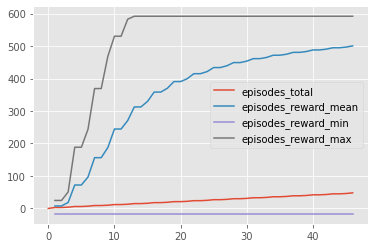

In [23]:
episodes_this_iter = df['episodes_this_iter']
episodes_total = df['episodes_total']
episodes_reward_mean = df['episode_reward_mean']
episodes_reward_max = df['episode_reward_max']
episodes_reward_min = df['episode_reward_min']

df_episodes = pd.DataFrame(episodes_total)
df_episodes['episodes_reward_mean'] = df['episode_reward_mean']
df_episodes["episodes_reward_min"] = df['episode_reward_min']
df_episodes["episodes_reward_max"] = df['episode_reward_max']

df_episodes.plot.line()

In [24]:
import ray.rllib.agents.dqn as dqn


checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(('episode_reward_mean'), mode='max'))

checkpoint_path = checkpoints[0][0]

# Restore agent
agent = dqn.DQNTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 0.01, #8e-6
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        'simple_optimizer': False
    }
)

agent.restore(checkpoint_path)

2021-11-16 21:29:20,863	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2021-11-16 21:29:20,864	INFO dqn.py:141 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=1316) 2021-11-16 21:29:24,485	INFO rollout_worker.py:1540 -- Validating sub-env at vector index=0 ... (ok)
(pid=1316) 2021-11-16 21:29:24,486	DEBUG rollout_worker.py:1363 -- Creating policy for default_policy
(pid=1316) 2021-11-16 21:29:24,490	DEBUG catalog.py:702 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f9fac20ebb0>: Box([[-inf -inf -inf -inf -inf]
(pid=1316)  [-inf -inf -inf -inf -inf]
(pid=1316)  [-inf -inf -inf -inf -inf]
(pid=1316)  [-inf -inf -inf -inf -inf]
(pid=1316)  [-inf -inf -inf -inf -inf]
(pid=1316)  [-inf -inf -inf -inf -inf]
(pid=1316)  [-inf -inf -inf -inf -inf]
(pid=1316)  

2021-11-16 21:29:24,564	WARNING deprecation.py:38 -- DeprecationWarning: `ReplayBuffer(size)` has been deprecated. Use `ReplayBuffer(capacity)` instead. This will raise an error in the future!
2021-11-16 21:29:24,567	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-11-16 21:29:24,589	INFO trainable.py:393 -- Restored on 100.96.7.135 from checkpoint: /domino/datasets/local/ODSC-West-Ray-Tutorial/DQN/DQN_TradingEnv_0a92f_00000_0_2021-11-16_21-20-37/checkpoint_000001/checkpoint-1
2021-11-16 21:29:24,589	INFO trainable.py:401 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 1.1246681213378906, '_episodes_total': 0}
(pid=1316) 2021-11-16 21:29:24,519	INFO torch_policy.py:145 -- TorchPolicy (worker=1) running on CPU.
(pid=1316) 2021-11-16 21:29:24,528	DEBUG rollout_worker.py:723 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7f9fac1ccdf0> (<TradingEnv instance>), policies {}
(pid=1317)

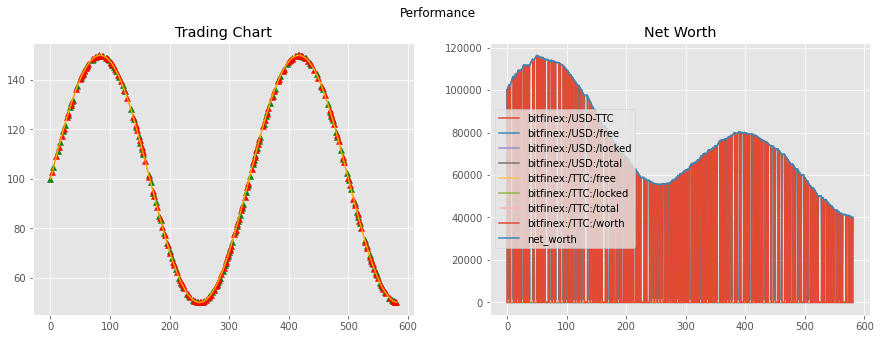

In [25]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    #action = agent.compute_action(obs)
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()